# Advanced Data Wrangling II: Reshaping DataFrames

files needed = ('gameshow.csv','WEOOct2021all.csv','zillow.csv')

We are learning how to deal with complex datasets in pandas. We began by tackling the multiIndex and now we turn to panel data and its various representations.  

Panel data have (at least) three dimensions, for example, a panel might record

1. several variables (income, age, spending on gasoline)
2. regarding several people
3. over time

The multiIndex gives us a natural way to handle this data. In this notebook, we work on ways to get our datasets into shapes that are amenable to analysis. 

Reshaping is important and necessary, and often a particularly painful aspect of using administrative data or data from apis.

A standard structure for a DataFrame has **observations as rows and variables as columns**. Many methods expect DataFrames to be organized this way but raw data are often not organized in this manner. This DataFrame structure is often referred to as *tidy data*. [This](https://www.jstatsoft.org/article/view/v059i10) article by Wickham lays out the ideas. The first three sections are great reading. The rest of the paper shows how to tidy up data in R. We can do the same things in python. With enough suffering, you can do it in STATA, too. 

In [1]:
import pandas as pd                 # load pandas and shorten it to pd
import datetime as dt               # load datetime and shorten it to dt
import matplotlib.pyplot as plt     # for making figures
import seaborn as sns
import numpy as np
import os

In [4]:
os.chdir('/Users/jackson/Documents/ECON570')
os.getcwd()

'/Users/jackson/Documents/ECON570'

## Some simple panel data
Load the 'gameshow.csv' file. It contains scores and wins for the award-winning British game show [Taskmaster](https://www.theatlantic.com/culture/archive/2023/03/taskmaster-game-show-productivity-parody/673225/). The different dimensions of the data are: **variables** (score, win); **series** (1-14 series, or seasons); **contestants** (by name); and  **episodes** (1-10). The column **value** contains the data associated with the contestant-episode-variable triplet. Each contestant appears in only one series; this would not be true if the data included holiday specials or tournaments. 
 
\[The data are were compiled on a [fan Wiki site](https://taskmaster.fandom.com/wiki/Contestant_Statistics); I make no claims regarding the accuracy of the data or anything else on the site. If you were using data like these in a project, you would want to verify the accuracy yourself or find a more trustworthy source.\] 

In [5]:
# load a data file with the score and win pattern of the game show
# notice that value is sometimes missing - fewer episodes in some series
game = pd.read_csv('data/gameshow.csv') 
game.sample(5)

,series,contestant,episode,var,value
497,5,Sally Phillips,9,win,NaN
637,7,Jessica Knappett,9,win,0.0
33,1,Josh Widdicombe,7,win,NaN
548,6,Liza Tarbuck,5,score,25.0
170,2,Katherine Ryan,6,score,NaN


In [6]:
game.describe()

,series,episode,value
count,1400.000000,1400.000000,1220.000000
mean,7.500000,5.500000,7.926230
std,4.032569,2.873308,8.261783
min,1.000000,1.000000,0.000000
25%,4.000000,3.000000,0.000000
50%,7.500000,5.500000,2.000000
75%,11.000000,8.000000,16.000000
max,14.000000,10.000000,30.000000


In [7]:
game.dtypes

series          int64
contestant     object
episode         int64
var            object
value         float64
dtype: object

### Long vs. wide (or stacked vs. unstacked)

The data in the file we just loaded is formatted as **long**: There are lots of rows and not many columns. Moving between long and **wide** (lots of columns, fewer rows) is a common task in setting up panel data sets. 

Pandas calls long data **stacked** and wide data **unstacked**. We use the `.stack()` and `.unstack()` methods for moving between long and wide with multiIndexed data. Stack and unstack do not work in place. They always return a copy, so we need to assign it to a variable.

The typical workflow is:

1. Set up the index
2. Stack or unstack

### Set up the index
`.stack()` and `.unstack()` work from the index. Since our data may be many-dimensional, multiIndexes are often useful. We start by getting the index set so that we can reshape our data. 

In [8]:
# move everything but the data values to the index
game = game.set_index(['series', 'contestant', 'episode', 'var'])
game = game.sort_index()
game

value
series contestant     episode var         
1      Frank Skinner  1       score   19.0
                              win      1.0
                      2       score    9.0
                              win      0.0
                      3       score   15.0
...                                    ...
14     Sarah Millican 8       win      0.0
                      9       score   18.0
                              win      0.0
                      10      score   15.0
                              win      0.0

[1400 rows x 1 columns]

## Unstack
We **unstack the data** to put the variables into columns. This creates a multiIndex over the columns, which is a new concept. We'll deal with this below.

In [9]:
# We pass unstack the name of the index level to take out of the index and spread across the rows. 
game_us = game.unstack('var') 
game_us.head(10)

value     
var                          score  win
series contestant    episode           
1      Frank Skinner 1        19.0  1.0
                     2         9.0  0.0
                     3        15.0  0.0
                     4        14.0  0.0
                     5        20.0  1.0
                     6        16.0  0.0
                     7         NaN  NaN
                     8         NaN  NaN
                     9         NaN  NaN
                     10        NaN  NaN

The data are now **wide** (or, at least, wider) and **tidy**. We have shortened the number of rows and increased the number of columns. This is my preferred way to shape this data because it puts the unit of observation in the row index. In this case, the unit of observation is a contestant-episode. 

Some of the series had fewer than 10 episodes, so both `score` and `win` are missing. Let's drop missings.

In [10]:
game_us.dropna(inplace=True)
game_us.head(10)

value     
var                            score  win
series contestant      episode           
1      Frank Skinner   1        19.0  1.0
                       2         9.0  0.0
                       3        15.0  0.0
                       4        14.0  0.0
                       5        20.0  1.0
                       6        16.0  0.0
       Josh Widdicombe 1        13.0  0.0
                       2        16.0  0.0
                       3        22.0  1.0
                       4        16.0  1.0

### Removing a level
The column index is now a multiIndex:

In [11]:
game_us.columns

MultiIndex([('value', 'score'),
            ('value',   'win')],
           names=[None, 'var'])

The outermost level of the column multiIndex is 'value' and is not very useful. Let's drop it.

Note that the level does not have a name associated with it (`None` is not a name) so we need to use the number associated with the level. 

In [12]:
game_us.columns = game_us.columns.droplevel(level = 0)
game_us.head(10)

var                             score  win
series contestant      episode            
1      Frank Skinner   1         19.0  1.0
                       2          9.0  0.0
                       3         15.0  0.0
                       4         14.0  0.0
                       5         20.0  1.0
                       6         16.0  0.0
       Josh Widdicombe 1         13.0  0.0
                       2         16.0  0.0
                       3         22.0  1.0
                       4         16.0  1.0

In [13]:
game_us.columns

Index(['score', 'win'], dtype='object', name='var')

### Creating new variables
I want to know the scores conditional on winning. I don't want the non-winning scores to be filled in with anything; for example, if they were filled in with zeros, and I tried to calculate the mean, it would be biased downward by the many zero observations.

In [15]:
#game_us['score_win'] = game_us[game_us['win']==1]['score']
# Alternative method using .loc[]
game_us.loc[game_us['win']==1, 'score_win'] = game_us['score']
game_us

var                            score  win  score_win
series contestant     episode                       
1      Frank Skinner  1         19.0  1.0       19.0
                      2          9.0  0.0        NaN
                      3         15.0  0.0        NaN
                      4         14.0  0.0        NaN
                      5         20.0  1.0       20.0
...                              ...  ...        ...
14     Sarah Millican 6         19.0  1.0       19.0
                      7         15.0  0.0        NaN
                      8         17.0  0.0        NaN
                      9         18.0  0.0        NaN
                      10        15.0  0.0        NaN

[610 rows x 3 columns]

As usual, pandas handles our missing observations gracefully. 

### Unstack using multiple variables
We can unstack again to make the data even wider. As usual, we pass a list of names whose (combinations of) values we now want to be shown as columns.
```python
game.unstack(['episode', 'var'])
```
Now we have missings again, and the data are at the contestant level.

In [16]:
# We pass unstack the name of the index level to take out of the index and spread across the rows. 
game_us2 = game.unstack(['episode', 'var'])
game_us2.head(10)

value                                              \
episode                      1          2          3          4          5    
var                       score  win score  win score  win score  win score   
series contestant                                                             
1      Frank Skinner       19.0  1.0   9.0  0.0  15.0  0.0  14.0  0.0  20.0   
       Josh Widdicombe     13.0  0.0  16.0  0.0  22.0  1.0  16.0  1.0  18.0   
       Roisin Conaty        7.0  0.0  21.0  1.0   9.0  0.0   9.0  0.0  14.0   
       Romesh Ranganathan  19.0  1.0  14.0  0.0  22.0  1.0  10.0  0.0  16.0   
       Tim Key             17.0  0.0  18.0  0.0  16.0  0.0   9.0  0.0  10.0   
2      Doc Brown            9.0  0.0  18.0  0.0  21.0  0.0  18.0  1.0  12.0   
       Joe Wilkinson        8.0  0.0  13.0  0.0  25.0  0.0  12.0  0.0  11.0   
       Jon Richardson      18.0  0.0  25.0  1.0  17.0  0.0  17.0  0.0  13.0   
       Katherine Ryan      17.0  0.0  19.0  0.0  30.0  1.0  15.0  0.0  13.0   
       Richard Osman       20.0  1.0  15.0  0.0  27.0  0.0   5.0  0.0  19.0   

                                                                               \
episode                           6          7         8         9         10   
var                        win score  win score win score win score win score   
series contestant                                                               
1      Frank Skinner       1.0  16.0  0.0   NaN NaN   NaN NaN   NaN NaN   NaN   
       Josh Widdicombe     0.0   9.0  0.0   NaN NaN   NaN NaN   NaN NaN   NaN   
       Roisin Conaty       0.0   8.0  0.0   NaN NaN   NaN NaN   NaN NaN   NaN   
       Romesh Ranganathan  0.0  12.0  0.0   NaN NaN   NaN NaN   NaN NaN   NaN   
       Tim Key             0.0  18.0  1.0   NaN NaN   NaN NaN   NaN NaN   NaN   
2      Doc Brown           0.0   NaN  NaN   NaN NaN   NaN NaN   NaN NaN   NaN   
       Joe Wilkinson       0.0   NaN  NaN   NaN NaN   NaN NaN   NaN NaN   NaN   
       Jon Richardson      0.0   NaN  NaN   NaN NaN   NaN NaN   NaN NaN   NaN   
       Katherine Ryan      0.0   NaN  NaN   NaN NaN   NaN NaN   NaN NaN   NaN   
       Richard Osman       1.0   NaN  NaN   NaN NaN   NaN NaN   NaN NaN   NaN   

                               
episode                        
var                       win  
series contestant              
1      Frank Skinner      NaN  
       Josh Widdicombe    NaN  
       Roisin Conaty      NaN  
       Romesh Ranganathan NaN  
       Tim Key            NaN  
2      Doc Brown          NaN  
       Joe Wilkinson      NaN  
       Jon Richardson     NaN  
       Katherine Ryan     NaN  
       Richard Osman      NaN

### Plotting with panels
`game_us2` is too wide for our purposes. Let's stick with `game_us`.

Let's plot the scores across episodes, for a recent series. The plotting is straightforward, but we need to use our multiIndex skills to select the data. Also, notice how I use the `zip` function with a loop to automate the plotting of five different lines.

In [17]:
# Subset the data
game_us14 = game_us.xs(14, level='series')
# Get the contestant names for the most recent series
contestants = list(game_us14.xs(1, level='episode').index)
contestants

['Dara Ó Briain',
 'Fern Brady',
 'John Kearns',
 'Munya Chawawa',
 'Sarah Millican']

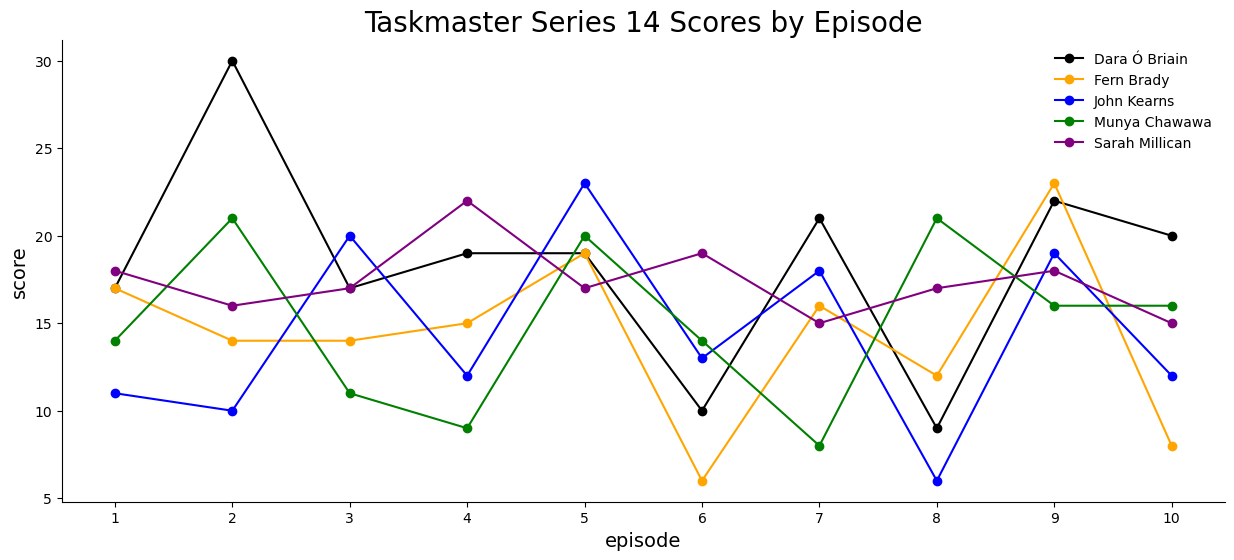

In [18]:
fig, ax = plt.subplots(figsize=(15,6))

for con, col in zip(contestants, ['black', 'orange', 'blue', 'green', 'purple']):
    ax.plot(game_us14.loc[con].index, game_us14.loc[con, 'score'], color=col, marker = 'o', label=con)

sns.despine(ax=ax)

ax.set_title('Taskmaster Series 14 Scores by Episode', fontsize=20)
ax.legend(frameon=False)
ax.set_ylabel('score', fontsize=14)
ax.set_xlabel('episode', fontsize=14)

ax.set_xticks(range(1,11,1))

plt.show()

What have we here? Dara Ó Briain won the series, but lost many episodes. Sarah Millican wins the "steady as she goes" prize for least score volatility. John Kearns seems countercyclical - he must have a different set of skills than the other contestants.

## Stack
We can **stack the data** to put the variables back on the rows. 

In [19]:
# stack() shifts the columns to rows. 
game_s = game_us.stack()       
game_s

series  contestant      episode  var      
1       Frank Skinner   1        score        19.0
                                 win           1.0
                                 score_win    19.0
                        2        score         9.0
                                 win           0.0
                                              ... 
14      Sarah Millican  8        win           0.0
                        9        score        18.0
                                 win           0.0
                        10       score        15.0
                                 win           0.0
Length: 1365, dtype: float64

This is a Series object&mdash;it only has one column of data and the rest is the index.

Let's get this ready to save as long data, like it was when we read it in.

1. Reset the index to move them back to columns. Now we have a DataFrame rather than a Series.
2. Give the 'value' column a name. 

In [20]:
game_s = game_s.reset_index()
game_s.head()

,series,contestant,episode,var,0
0,1,Frank Skinner,1,score,19.0
1,1,Frank Skinner,1,win,1.0
2,1,Frank Skinner,1,score_win,19.0
3,1,Frank Skinner,2,score,9.0
4,1,Frank Skinner,2,win,0.0


In [21]:
game_s.rename(columns={0 :'value'}, inplace=True)
game_s.head()


,series,contestant,episode,var,value
0,1,Frank Skinner,1,score,19.0
1,1,Frank Skinner,1,win,1.0
2,1,Frank Skinner,1,score_win,19.0
3,1,Frank Skinner,2,score,9.0
4,1,Frank Skinner,2,win,0.0


In [22]:
# Now save it. 
game_s.to_csv('game_data_updated.csv', index=False)  #index = False does not print the index

## Alternative to Stack: Melt
The function `melt` acts on DataFrames much like `stack`. These functions achieve similar results, but do so somewhat differently. Let's give it a try.

`melt` has three main inputs:

* value_vars
* id_vars
* ignore_index

We pass value_vars a list of columns that we want to stack. We pass id_vars a list of identifier columns that we want to keep as columns. Any non-indexed variables not included in value_vars or id_vars will not end up in the returned DataFrame.

By default, `melt` will drop the index or MultiIndex. If the MultiIndex contains some (or all) of the variables that we want to keep, we can use the ignore_index=False option.

In our case, we pass value_vars=['score', 'win', 'score_win'] along with the ignore_index=False option. We don't need to include any more id_vars because they are all included in our MultiIndex.

In [23]:
game_melt = game_us.melt(value_vars=['score', 'win', 'score_win'], ignore_index=False)
game_melt

var  value
series contestant     episode                  
1      Frank Skinner  1            score   19.0
                      2            score    9.0
                      3            score   15.0
                      4            score   14.0
                      5            score   20.0
...                                  ...    ...
14     Sarah Millican 6        score_win   19.0
                      7        score_win    NaN
                      8        score_win    NaN
                      9        score_win    NaN
                      10       score_win    NaN

[1830 rows x 2 columns]

That looks about right! A few things to note.

* `stack` moves var from the column index to row index, so the resulting Series is indexed and sorted by var.
* In contrast, `melt` simply took score, win, and score_win and melted them all into a new column called var.
* `melt` did not drop the NaN values.

We can make these changes manually.

In [24]:
# add 'var' to the MultiIndex
game_melt.set_index('var', append=True, inplace=True)
# sort the MultiIndex
game_melt.sort_index(inplace=True)
# drop na values
game_melt.dropna(inplace=True)
game_melt

value
series contestant     episode var             
1      Frank Skinner  1       score       19.0
                              score_win   19.0
                              win          1.0
                      2       score        9.0
                              win          0.0
...                                        ...
14     Sarah Millican 8       win          0.0
                      9       score       18.0
                              win          0.0
                      10      score       15.0
                              win          0.0

[1365 rows x 1 columns]

This is now pretty much identical to the version produced by `.stack()`

To summarize: stack and melt can achieve the same results, but melt doesn't leverage the MultiIndex in the same way that stack does.

## Practice

Let's use these tools with some real world economic data. The data are messy and will require some cleaning up and 'wrangling.'

We will work with the IMF's World Economic Outlook, which contains historical data and the IMF's forecasts for many countries and variables. I've cleaned this up a bit already, but it still has the wrong shape. 

The data are in the file 'WEOOct2021all.csv'.

There are two ways to do this practice. 

**The hard way.** The final DataFrame should have a row index with two levels: 'ISO' and the date. The column index should have three levels: 'Variable', 'Description', and 'Units'.

   You figure out how to get it that way.
   
**The less hard way.** Follow the steps below.  

In [27]:
# Load the file 'WEOOct2021all.csv' into a DataFrame and check dtypes
weo_us = pd.read_csv('data/WEOOct2021all.csv')
weo_us.dtypes

ISO             object
Variable        object
Description     object
Units           object
1980           float64
1981           float64
1982           float64
1983           float64
1984           float64
1985           float64
1986           float64
1987           float64
1988           float64
1989           float64
1990           float64
1991           float64
1992           float64
1993           float64
1994           float64
1995           float64
1996           float64
1997           float64
1998           float64
1999           float64
2000           float64
2001           float64
2002           float64
2003           float64
2004           float64
2005           float64
2006           float64
2007           float64
2008           float64
2009           float64
2010           float64
2011           float64
2012           float64
2013           float64
2014           float64
2015           float64
2016           float64
2017           float64
2018           float64
2019       

0. Load the file 'WEOOct2021all.csv' into a DataFrame. Check your dtypes. 

1. Set the index to be 'Variable', 'ISO', 'Description', and 'Units'. Now the index will have everything in it that is not data. 
2. Stack the data. 

Great. Now are data are stacked, or long. Let's get the DataFrame into the shape we want: Observations in the row index and variables in the column index. 

3. Unstack 'Variable', 'Description', and 'Units', in that order. We want the variable names on the outermost level.

Looks good!

*A few extras:* How do we work with all these MultiIndex rows and columns?

In the row index, the inner level is not named. We can use `.set_names()` to add a name.

In [28]:
weo_us.index.set_names('Year', level=1, inplace=True)
weo_us.head()

ValueError: Level must be None for non-MultiIndex

What if we wanted a slice with just the 'Surplus' column?

In [29]:
weo_us.xs('Surplus', level=0, axis=1)

TypeError: Index must be a MultiIndex

We can also drop some of the extraneous column levels if we want to.

In [ ]:
weo_us.columns = weo_us.columns.droplevel(level = [1,2])
weo_us.head()

## Additional Practice: Try at home

The data are from [Zillow](https://www.zillow.com/research/data/). It is housing inventory by metro area&mdash;i.e., the number of unique listings that were active at any time in a given month.  

Now that you have had some practice, let's do this **the hard way.** 

1. The final DataFrame should have a row index with two levels: 'RegionName' and the date. The column index has only one level. 

   You figure out how to get it that way.
   
The data are in the file 'zillow.csv'

2. Once you get your DataFrame in good shape, try plotting the inventory level for Madison, WI. What patterns do you notice? How does Madison compare to the United States as a whole?